<a href="https://colab.research.google.com/github/marcelobenedito/quarantine_covid19_behavior_analysis/blob/master/quarantine_covid19_behavior_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Quarantine Covid-19 behavior analysis**

*It will be collect data tweets about COVID-19, quarantine and related about. This content will analysed to extract sentiment and main user behavior that makes don't stay home.*

## **1. Initial settings**

**Install libraries**

In [16]:
!pip3 install unidecode
!pip3 install emoji
!pip3 install joblib

     |████████████████████████████████| 245kB 8.2MB/s 
     |████████████████████████████████| 51kB 3.3MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=8aab6de9affae5051b93b1a23bf64647cf3d4ebb5f3f049677423559112fa21e
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


**Required imports**

In [137]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
import string
import tweepy
import time
import json
import nltk
import re
from datetime import timedelta
from google.colab import drive
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from emoji import demojize
from pytz import timezone

**Mounting drive and downloading stop words**

In [18]:
drive.mount('/content/drive')
nltk.download('stopwords')

Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Add America/São Paulo timezone for this notebook**

In [19]:
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/America/Sao_Paulo /etc/localtime
!date

tz = timezone('America/Sao_Paulo')

Mon Oct  5 17:51:29 -03 2020


In [20]:
cd 'drive/My Drive/TCC/credentials'

/content/drive/My Drive/TCC/credentials


In [21]:
from credentials import *

## **2. Extract tweets**

In [ ]:
cd '../Tweets'

/content/drive/My Drive/TCC/Tweets


**Handling the rate limit using cursors**

In [ ]:
def limit_handled(cursor, finishes):
    while True:
        try:
            if finishes == True:
              return
            yield cursor.next()
        except (tweepy.RateLimitError, StopIteration):
            if finishes == True:
              return
            else:
              print('\r{} [tweepy.RateLimitError] Rate limit exception...'.format(dt.datetime.now().astimezone(tz)), end='')
              time.sleep(15*60)

**Create a funcion to search tweets**

In [ ]:
def search_tweets(search_filter, since, until, limit, language):
  finishes = False
  for tweet in tweepy.Cursor(api.search, q=search_filter, until=until, lang=language, tweet_mode="extended").items(limit):
    tweets.append(tweet)
    print('\r{} [INFO] {} collected tweets!'.format(dt.datetime.now().astimezone(tz), len(tweets)), end='');
    if limit != None and len(tweets) == limit:
      return tweets

**API authentication**

In [ ]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

**Defining filters used in search**

In [ ]:
""" não estou saindo "não estou saindo" (quarentena OR covid) (#covid-19 OR #coronavírus OR #coronavirus OR #covid OR #quarentena) lang:pt until:2020-01-31 since:2020-01-01 -filter:replies """

contains_both_words = ''
exact_phrase = ''
#contains_any_words = '(quarentena OR covid OR coronavirus OR isolamento OR festa OR role OR evento OR balada OR sair OR saindo)'
contains_any_words = ('(quarentena OR covid OR covid-19 OR coronavirus OR coronavírus'
                      ' OR isolamento OR isolado OR isolar OR festa OR rolê OR role'
                      ' OR evento OR balada OR sair OR saindo OR indo OR vamos OR vou'
                      ' OR churrasco OR churras OR churrascão OR rodeio OR show'
                      ' OR viagem OR viajar)')
contains_any_hashtags = ''
no_retweet = ''
language = 'pt'
#since = dt.date(2020,1,1)
until = dt.date.today() - dt.timedelta(days=7)
since = 'since:2020-01-01'
#until = 'until:2020-07-01'
limit = 30000

search_filter = contains_both_words + ' ' + exact_phrase + ' ' + contains_any_words + ' ' + contains_any_hashtags + ' ' + since + no_retweet

**Extracting tweets based on search filter**

In [ ]:
tweets = []
started_at = dt.datetime.now()
print('{} [INFO] starting search...'.format(dt.datetime.now().astimezone(tz)))
tweets = search_tweets(search_filter, since, until, limit, language)
finished_at = dt.datetime.now()

2020-10-04 18:13:22.452408-03:00 [INFO] starting search...
2020-10-04 20:59:28.545762-03:00 [INFO] 30000 collected tweets!

**Transform Json to DataFrame and export to CSV file**

In [ ]:
df = pd.DataFrame({
      'created_at': tweet.created_at,
      'user_id': tweet.user.id, 
      'screen_name': tweet.user.screen_name,
      'geo': tweet.geo,
      'coordinates': tweet.coordinates,
      'place': tweet.place,
      'tweet_id': tweet.id, 
      'text': unidecode(tweet.full_text),
      'class': ''
  } for tweet in tweets)

df.to_csv('tweets_{}.csv'.format(dt.datetime.now().astimezone(tz)), encoding = 'utf-8', index = False)

**Printing found tweets**

In [ ]:
df.head()

,created_at,user_id,screen_name,geo,coordinates,place,tweet_id,text,class
0,2020-09-26 23:59:59,375304898,Mirella_VCosta,None,None,None,1310006235589226496,RT @pedrohelenov: Sim gente estou esperando 20...,
1,2020-09-26 23:59:59,957416619684352000,GracileneOliv15,None,None,None,1310006235564060673,"RT @ounojo: ""nao vou mais deixa isso me abalar...",
2,2020-09-26 23:59:59,3912435976,feoliveirap15,None,None,None,1310006235429830656,Eu n sei se vou aguentar ver os tres cantando ...,
3,2020-09-26 23:59:59,1265096645970210816,Ray090815,None,None,None,1310006235132047366,RT @CarollRocha: Vou tirar uma foto dessa nunca?,
4,2020-09-26 23:59:59,2959237217,souateuedigomds,None,None,None,1310006235022974979,vou comer pizza aqui q se foda,


**Write to json file**

In [ ]:
df = pd.DataFrame(tweets)
df.to_json('tweets_{}.json'.format(dt.datetime.now().astimezone(tz)))
df.head()

,0
0,Status(_api=<tweepy.api.API object at 0x7fab0c...
1,Status(_api=<tweepy.api.API object at 0x7fab0c...
2,Status(_api=<tweepy.api.API object at 0x7fab0c...
3,Status(_api=<tweepy.api.API object at 0x7fab0c...
4,Status(_api=<tweepy.api.API object at 0x7fab0c...


## **3. Preprocessing**

This process is used to preprocess the tweet text:

 - Tokenize words;
 - Remove all stop words; 
 - Punctuaction rules; 
 - Unused characters;
 - Links from tweets.

In [22]:
cd '../Tweets'

/content/drive/My Drive/TCC/Tweets


In [23]:
def preprocessing(pd_serie):

  # Converting to lowercase
  pd_serie = pd_serie.str.lower()

  # Removing unused links
  pd_serie = pd_serie.str.replace(r"(http|@)\S+", "")

  # Transform short negation form
  pd_serie = pd_serie.str.split(' ', expand=True).replace('n','não').fillna('').apply(' '.join, 1)
  pd_serie = pd_serie.str.split(' ', expand=True).replace('ñ','não').fillna('').apply(' '.join, 1)
  pd_serie = pd_serie.str.split(' ', expand=True).replace('naum','não').fillna('').apply(' '.join, 1)

  # Remove repetitions
  pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
  pd_serie = pd_serie.str.replace(pattern, r"\1")

  # Removing stop words
  sw = stopwords.words('portuguese')
  sw.remove('não')
  sw.remove('sem')
  sw.remove('estou')

  pd_serie = pd_serie.apply(
      lambda pd_serie: ' '.join([unidecode(word) for word in pd_serie.split() if word not in sw])
  )

  # Removing punctuation rules
  pd_serie = pd_serie.str.translate(str.maketrans('', '', string.punctuation))

  # Remove special chars
  pd_serie = pd_serie.apply(demojize)
  pd_serie = pd_serie.str.replace(r"::", ": :")
  pd_serie = pd_serie.str.replace(r"’", "'")
  pd_serie = pd_serie.str.replace(r"[^a-z\':_]", " ")

  return pd_serie

**Add negation tag to make emphasis in a negative phrase**

In [24]:
def negative_phrase(phrase):
  negative_word = 'nao'
  has_negative_word = False
  new_phrase = []
  for word in phrase.split():
    if has_negative_word == True:
      word = word + '_NAO'
    if word == negative_word:
      has_negative_word = True
    new_phrase.append(word)
  return (' '.join(new_phrase))

**Open stored tweets from CSV file**

In [25]:
df = pd.read_csv('train.csv')
df.head()

,created_at,user_id,screen_name,geo,coordinates,place,tweet_id,text,class
0,8/12/2020 23:59,1.240000e+18,lavnia57,NaN,NaN,NaN,1.290000e+18,Ia dar um chutao nela p sair da frente kkkkkkk...,0
1,8/12/2020 23:59,1.290000e+18,mendsbridgerton,NaN,NaN,NaN,1.290000e+18,Eu sempre te achei famosinha ai eu tinha medo ...,0
2,8/12/2020 23:59,1.060000e+18,jhe_yaya,NaN,NaN,NaN,1.290000e+18,RT @clatruvs: eu no banheiro da balada falando...,0
3,8/12/2020 23:59,1.270000e+18,Yasminpaivax,NaN,NaN,NaN,1.290000e+18,RT @clatruvs: eu no banheiro da balada falando...,0
4,8/12/2020 23:59,1.280000e+18,kopp_taliaa,NaN,NaN,NaN,1.290000e+18,Mano pq sair falando?? pqp,0


**Count lines in dataset**

In [26]:
df.text.count()

33726

**Removing duplicate lines**

In [27]:
df.drop_duplicates(['text'], inplace=True)

**Count lines**

In [28]:
df.text.count()

24948

**Preproccessing data**

In [29]:
classes = df['class']
tweets = df.text
tweets = preprocessing(tweets)
tweets

0                       ia dar chutao nela p sair frente k
1        sempre achei famosinha ai medo interagir vamos...
2        rt banheiro balada falando pra menina q acabei...
4                                 mano pq sair falando pqp
5        entao vamos ficar separadas pq nao vou mandar ...
                               ...                        
33721    rt favor doria fiel protocolo nao tome ivermec...
33722    mlkd ta td aq base vou clc beat p noix resenha...
33723              real to entendendo so to indo ta ligado
33724    vou voltar malhar segunda aff vou ficar chata ...
33725    queria ta churrasco familia cantando molejo ma...
Length: 24948, dtype: object

## **4. Training and predict process**

**Required libraries**

In [127]:
import sklearn
import joblib
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

**Define function to create pipeline model**

In [31]:
def pipeline(model, n_gram, negation):
  pipe = Pipeline([('vectorizer', CountVectorizer()), ('model', model)])

  if negation:
    return Pipeline([
      ('vectorizer', CountVectorizer(tokenizer=lambda phrase: negative_phrase(phrase), ngram_range=n_gram)), 
      ('model', model)
    ])    
  else:
    return Pipeline([('vectorizer', CountVectorizer(ngram_range=n_gram)), ('model', model)])

**Define individual score function**

In [32]:
def score(model_name, pipeline):
  score = pipeline.score(X_test, y_test)
  print('\r{} [INFO] Score of {} model with testing data is {:.1%}\n'
    .format(dt.datetime.now().astimezone(tz), model_name, score))
  return score

**Define cross validation function**

In [147]:
def cross_validation(model_name, pipe, X_train, y_train, k_fold):
  scores = cross_val_score(pipe, X_train, y_train, cv=k_fold, n_jobs=-1)
  score = np.mean(scores)
  print("\r{0} [INFO] Score for {1} model: {2}".format(dt.datetime.now().astimezone(tz), model_name, score))
  return score


**Define training function**
- Train model
- Get individual score for MLP model
- Make cross validation

In [44]:
def fit(model_name, pipeline, X_train, y_train, k_fold):
  pipe.fit(X_train, y_train)
  print('\r{} [INFO] finish fit model...\n'
    .format(dt.datetime.now().astimezone(tz)))
  print('\r{} [INFO] starting cross validation...\n'
    .format(dt.datetime.now().astimezone(tz)))
  cross_validation_score = cross_validation(model_name, pipeline, X_train, y_train, k_fold)
  return cross_validation_score

**Define plot confusion matrix function**

In [129]:
def confusion_matrix(pipeline, X_test, y_test):
  titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
  for title, normalize in titles_options:
      disp = plot_confusion_matrix(pipe, X_test, y_test,
                                  display_labels=[0, 1],
                                  cmap=plt.cm.Blues,
                                  normalize=normalize)
      disp.ax_.set_title(title)
  plt.show()

**Split x and y (feature and target)**

In [36]:
train_size=0.9
X_train, X_test, y_train, y_test = train_test_split(tweets,
                                                    classes,
                                                    train_size=train_size)

In [37]:
pd.DataFrame({'tweet': X_train, 'class': y_train})

,tweet,class
31715,vamos reagir marcar poxa,0
28367,rt so pra nao perder costume,0
23136,corinthians ta indo mal pior pqp,0
12968,rt nao gosta futebol blz ngm obrigado gostar n...,0
23721,temas escolher vou fazer tcc resultadolibria...,0
...,...,...
17027,tava tomando vinho agr cerveja preta daqui pou...,0
15410,vou dormir medo assistir farol,0
5393,varios tweets nao farei p nao magoar sentiment...,0
23235,vou ter ver video tbm k,0


In [38]:
pd.DataFrame({'tweet': X_test, 'class': y_test})

,tweet,class
28193,vou procurar,0
20597,vou comentar nada sobre jogo horrivel atgxfla,0
32492,to colica doida pra sair aula,0
27298,hm vou dormir dnv boa noite amgs,0
32509,pois entao oq q vou dizer ne olavo ensinou que...,0
...,...,...
26904,oi lindo tudo bem voce construir vida nova va...,0
895,rt pessoa querendo humilhar bts falando pediam...,0
4686,vou adorar ver programas esportivos desmerecen...,0
10914,amanha levo ta vou levar,1


### **3.1 - MLPClassifier**

**Create a Multilayer Perceptron Model**

- Hidden layers = 1
- Neurons = 10
- Learning rate = 0.01
- Max iteration = 500
- Optimizer = Stochastic Gradient Descent with no batch-size

In [40]:
"""mlp_model = MLPClassifier(hidden_layer_sizes=(10), 
                          solver='sgd', 
                          learning_rate_init=0.01,
                          max_iter=500,
                          random_state=113)"""

mlp_model = MLPClassifier(learning_rate_init=0.01,
                          random_state=42)                

**Create pipeline for MLP classifier**

In [41]:
'''pipe = Pipeline([('vectorizer', CountVectorizer()), ('model', mlp_model)])

pipe_bigrams = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,2))), ('model', mlp_model)])

pipe_negation = Pipeline([
  ('vectorizer', CountVectorizer(tokenizer=lambda phrase: negative_phrase(phrase))), 
  ('model', mlp_model)
])'''

pipe = pipeline(mlp_model, (1,2), False)

**Run training MLP model**

In [45]:
print('{} [INFO] starting train...'.format(dt.datetime.now().astimezone(tz)))
fit("MLP Classifier", pipe, X_train, y_train, 10)
print('{} [INFO] train successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-05 18:05:21.958068-03:00 [INFO] starting train...
2020-10-05 21:13:50.253410 [INFO] Score of MLP Classifier model with testing data is 96.8%

Score for MLP Classifier model: 0.9690465802108971
2020-10-05 19:00:30.999857-03:00 [INFO] train successful...


**Store MPL model in disk**

In [56]:
file_name = 'mlp_model'
joblib.dump(pipe, file_name)
print('\rMPL model was saved sucessfully!')

MPL model was saved sucessfully!


**Load MLP model**

In [57]:
pipe = joblib.load(file_name)

**Predict tweets**

In [58]:
tests = X_test
predict_result = pipe.predict(X_test)
pd.DataFrame(zip(tests, predict_result), columns=['tweet', 'class'])

,tweet,class
0,vou procurar,0
1,vou comentar nada sobre jogo horrivel atgxfla,0
2,to colica doida pra sair aula,0
3,hm vou dormir dnv boa noite amgs,0
4,pois entao oq q vou dizer ne olavo ensinou que...,0
...,...,...
2490,oi lindo tudo bem voce construir vida nova va...,0
2491,rt pessoa querendo humilhar bts falando pediam...,0
2492,vou adorar ver programas esportivos desmerecen...,0
2493,amanha levo ta vou levar,0


**Plot confusion matrix**

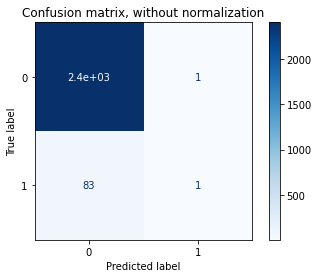

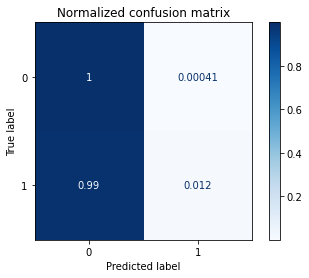

In [150]:
#print(pd.crosstab(y_test, predict_result, rownames=['Real'], colnames=['Predicted'], margins=True))
confusion_matrix(pipe, X_test, y_test)

**Test**

In [141]:
test = [
        (unidecode('Amanhã vou pro rolê com as amigas!!!')),
        (unidecode('Estou indo no mercado')),
        (unidecode('Alguém que ir comigo na festa semana que vem?')),
        (unidecode('Tô na festa da Júlia e tá muito top!!!! Vem pra ca amiga')),
        (unidecode('Daqui a pouco vou no hospital fazer exame de sangue')),
        (unidecode('n estou saindo de casa pra nada')),
        (unidecode('n estou saindo de casa')),
        (unidecode('150 dias sem sair de casa. Quarentena tá me deixando loucooooo!!! :/'))
       ]

new_test = pd.DataFrame(test, columns=['text'])
new_test = preprocessing(new_test['text'])
'''new_test = new_test.apply(
    lambda new_test: ' '.join([negative_phrase(phrase) for phrase in new_test])
)'''
new_test

0                           amanha vou pro role amigas
1                                   estou indo mercado
2                    alguem ir comigo festa semana vem
3               to festa julia ta top vem pra ca amiga
4          daqui pouco vou hospital fazer exame sangue
5                       nao estou saindo casa pra nada
6                                nao estou saindo casa
7        dias sem sair casa quarentena ta deixando ...
dtype: object

In [142]:
predict_result = pipe.predict(new_test)
pd.DataFrame(zip(new_test, predict_result), columns=['tweet', 'class'])

,tweet,class
0,amanha vou pro role amigas,0
1,estou indo mercado,1
2,alguem ir comigo festa semana vem,0
3,to festa julia ta top vem pra ca amiga,1
4,daqui pouco vou hospital fazer exame sangue,1
5,nao estou saindo casa pra nada,0
6,nao estou saindo casa,0
7,dias sem sair casa quarentena ta deixando ...,0


### **3.2 - Naive Bayes**

**Create a MultinomialNB Model**

In [152]:
naive_bayes_model = MultinomialNB()

**Create pipeline for MultinomialNB**

In [153]:
pipe = pipeline(naive_bayes_model, (1,2), False)

**Run training MultinomialNB model**

In [154]:
print('{} [INFO] starting train...'.format(dt.datetime.now().astimezone(tz)))
fit("MultinomialNB", pipe, X_train, y_train, 10)
print('{} [INFO] train successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-05 20:33:07.632800-03:00 [INFO] starting train...
2020-10-05 23:33:08.391692 [INFO] Score of MultinomialNB model with testing data is 96.6%

2020-10-05 20:33:13.679772-03:00 [INFO] Score for MultinomialNB model: 0.9707834169927434
2020-10-05 20:33:13.680015-03:00 [INFO] train successful...


**Plot confusion matrix**

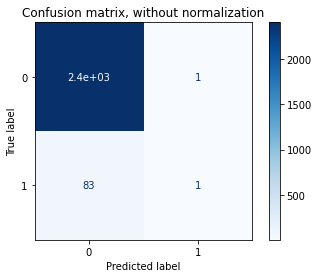

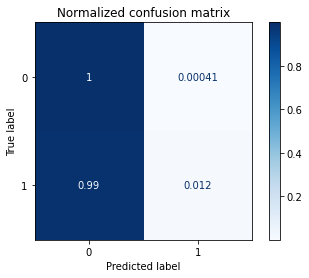

In [155]:
#print(pd.crosstab(y_train, results, rownames=['Real'], colnames=['Predicted'], margins=True))
confusion_matrix(pipe, X_test, y_test)

**Predict tweets**

In [156]:
tests = X_test
predict_result = pipe.predict(X_test)
pd.DataFrame(zip(tests, predict_result), columns=['tweet', 'class'])

,tweet,class
0,vou procurar,0
1,vou comentar nada sobre jogo horrivel atgxfla,0
2,to colica doida pra sair aula,0
3,hm vou dormir dnv boa noite amgs,0
4,pois entao oq q vou dizer ne olavo ensinou que...,0
...,...,...
2490,oi lindo tudo bem voce construir vida nova va...,0
2491,rt pessoa querendo humilhar bts falando pediam...,0
2492,vou adorar ver programas esportivos desmerecen...,0
2493,amanha levo ta vou levar,0


In [157]:
test = [
        (unidecode('Amanhã vou pro rolê com as amigas!!!')),
        (unidecode('Estou indo no mercado')),
        (unidecode('Alguém que ir comigo na festa semana que vem?')),
        (unidecode('Tô na festa da Júlia e tá muito top!!!! Vem pra ca amiga')),
        (unidecode('Daqui a pouco vou no hospital fazer exame de sangue')),
        (unidecode('n estou saindo de casa pra nada')),
        (unidecode('n estou saindo de casa')),
        (unidecode('150 dias sem sair de casa. Quarentena tá me deixando loucooooo!!! :/'))
       ]

new_test = pd.DataFrame(test, columns=['text'])
new_test = preprocessing(new_test['text'])
'''new_test = new_test.apply(
    lambda new_test: ' '.join([negative_phrase(phrase) for phrase in new_test])
)'''
new_test

0                           amanha vou pro role amigas
1                                   estou indo mercado
2                    alguem ir comigo festa semana vem
3               to festa julia ta top vem pra ca amiga
4          daqui pouco vou hospital fazer exame sangue
5                       nao estou saindo casa pra nada
6                                nao estou saindo casa
7        dias sem sair casa quarentena ta deixando ...
dtype: object

In [158]:
predict_result = pipe.predict(new_test)
pd.DataFrame(zip(new_test, predict_result), columns=['tweet', 'class'])

,tweet,class
0,amanha vou pro role amigas,0
1,estou indo mercado,0
2,alguem ir comigo festa semana vem,0
3,to festa julia ta top vem pra ca amiga,0
4,daqui pouco vou hospital fazer exame sangue,0
5,nao estou saindo casa pra nada,0
6,nao estou saindo casa,0
7,dias sem sair casa quarentena ta deixando ...,0


### **3.3 - Sequential Minimal Optimization**